# Moving From Digits to Fashion:
This notebook will take techniques learned in the previous notebook and apply them to a slightly harder data set: MNIST Fashion.

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.color_palette("Blues_d", n_colors=10, desat=1))

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

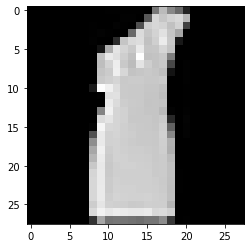

In [3]:
# Load batch and take a look at a sample image:
train_iter = iter(trainloader)
images, labels = train_iter.next()

image_0 = images[0].squeeze().numpy()
plt.imshow(image_0, cmap="Greys_r")

In [16]:
class LSequential(nn.Sequential):
    """
    A Small extension for ease of use of PyTorch's nn.Sequential model. Rather than define each layer's
    activations one at a time, the model is passed a tuple on initialization. The tuple contains the number of
    nodes desired at each layer. The model is then automatically initialized with ReLU activations at each inner
    layer and a log softmax activation at the final layer.

    All other behavior should match that of `torch.nn.Sequential`
    """
    def __init__(self, architecture, activation=("RelU", nn.ReLU()), out=("lsmax", nn.LogSoftmax(dim=1)), do=0.2):
        self.layers = architecture
        super().__init__(self.init_modules(architecture, activation, out, do))

    def init_modules(self, arch, activation, out, dropout):
        """
        A helper method that creates sequential modules and adds them to an `OrderedDict` object for passing
        to the super class `nn.Sequential`
        :param arch: Tuple where each element is the number of nodes in the corresponding layer
        :param activation: Default nn.ReLU(). This activation will be used for each internal layer, but not
            the output layer.
        :param out: Default nn.LogSoftmax. Output layer activation.
        :param dropout: Default 0.2, the dropout rate.
        :return: OrderedDict containing activation modules for passing to `nn.sequential`
        """
        n_layers = len(arch)
        modules = OrderedDict()
        a_name = activation[0]
        o_name = out[0]

        for i in range(n_layers - 2):
            modules[f'fc{i}'] = nn.Linear(layers[i], layers[i + 1])
            modules[f'{a_name}{i}'] = activation[1]
            modules[f'drop{i}'] = nn.Dropout(p=dropout)
        modules['fc_out'] = nn.Linear(layers[-2], layers[-1])
        modules[f'{o_name}'] = out[1]

        return modules

    def train_model(self, trainload, epochs, criterion=nn.NLLLoss(), optimizer=optim.Adam, lr=0.003, testload=None):
        """
        Train network parameters for given number of epochs.

        :param trainload: a DataLoader object containing training variables and targets used for training.
        :param testload: Optional. a DataLoader containing the validation set. If included, both training and
            validation loss will be tracked and can be plotted using model.plot_loss().
        :param epochs: Number of times the network will view the entire data set
        :param optimizer: Learning method. Default optim.Adam
        :param lr: Learning Rate. Default 0.003
        :param criterion: Loss function. Default nn.NLLLoss,
        :return:
        """
        opt = optimizer(self.parameters(), lr)

        self.testload = testload
        self.train_loss = []
        self.valid_loss = []
        self.accuracy = []

        for e in range(epochs):
            running_tl = 0
            running_vl = 0
            running_ac = 0
            for x, y in trainload:
                x = x.view(x.shape[0], -1)
                opt.zero_grad()
                loss = criterion(self(x), y)
                loss.backward()
                opt.step()
                running_tl += loss.item()

            if testload is not None:
                self.eval()
                with torch.no_grad():
                    for x, y in testload:
                        x = x.view(x.shape[0], -1)
                        lps = self(x)
                        ps = torch.exp(lps)
                        loss = criterion(lps, y)
                        _, topclass = ps.topk(1, dim=1)
                        acc = (topclass == y.view(*topclass.shape)).numpy()
                        running_ac += acc.mean()
                        running_vl += loss.item()
                    self.accuracy.append(running_ac / len(testload))
                    self.valid_loss.append(running_vl / len(testload))

            self.train()
            self.train_loss.append(running_tl / len(trainload))

    def plot_loss(self):
        """
        Plot training loss per epoch. Will also plot validation loss if a validation set was included.
        """
        if self.valid_loss:
            plt.plot(self.valid_loss, label='Validation Loss')
        plt.plot(self.train_loss, label='Training Loss')
        plt.legend()
        plt.show()

    def save(self, filepath):
        checkpoint = {
            'layers': self.layers,
            'state_dict': self.state_dict()
        }
        torch.save(checkpoint, filepath)

In [17]:
# Define network architecture:
layers = (784, 392, 196, 98, 10)
model = Network(layers)
model

Network(
  (drop0): Dropout(p=0.2, inplace=False)
  (fc0): Linear(in_features=784, out_features=392, bias=True)
  (relu0): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=392, out_features=196, bias=True)
  (relu1): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=196, out_features=98, bias=True)
  (relu2): ReLU()
  (fc_out): Linear(in_features=98, out_features=10, bias=True)
  (smax_out): LogSoftmax()
)

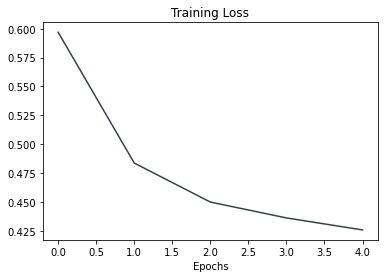

In [18]:
model.train(trainloader, 5, plot_loss=True)

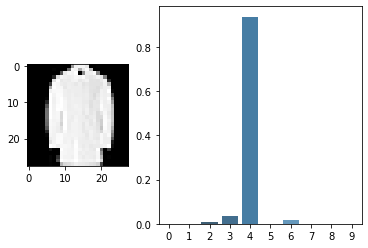

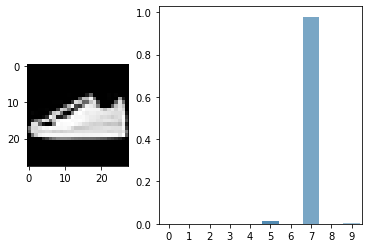

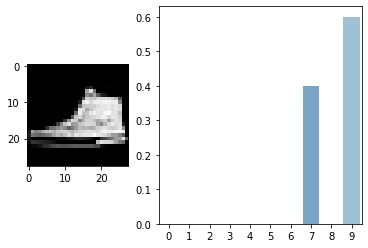

In [54]:
test_images, _ = iter(testloader).next()
 
for img in test_images[0:3]:
    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,2], 'height_ratios':[1]})
    ps = torch.exp(model(img.view(1, -1)))
    axes[0].imshow(img.numpy().squeeze(), cmap='Greys_r')
    sns.barplot(x=np.arange(10), y=ps.detach().numpy().squeeze(), ax=axes[1])
    plt.show()
